In [1]:
import pandas as pd
import os.path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import PolynomialFeatures

def format_csv(path : str):
    dataset_input  = pd.read_csv(path)
    domains_unique = dataset_input['domain'].unique()
    output_dict = {'timestamp':list()}
    for domain in domains_unique: output_dict[domain]=list()
    for timestamp in dataset_input['timestamp'].unique():
        x = dataset_input.loc[dataset_input['timestamp'] == timestamp]
        output_dict['timestamp'].append(timestamp)
        for domain in domains_unique: 
            serie = x.loc[x['domain'] == domain]['measure']
            output_dict[domain].append(serie.iloc[0]) if len(serie)>0 else output_dict[domain].append(np.nan)
    output_df = pd.DataFrame(output_dict)
    for key in output_df.keys():
        if key not in ['timestamp', 'phase']: output_df[key] = pd.to_numeric(output_df[key], errors='coerce', downcast="float")
    return output_df

def merge_datasets(input_datasets : dict):
    for name, dataset in input_datasets.items(): dataset['dataset'] = name
    return pd.concat(input_datasets.values())

def degree_choice(x,y, degree):
    polynomial_features= PolynomialFeatures(degree=degree)
    x_poly = polynomial_features.fit_transform(pd.DataFrame(x))

    model = LinearRegression()
    model.fit(x_poly, y)
    y_predict = model.predict(x_poly)

    return root_mean_squared_error(y,y_predict)

def best_degree(x, y):
    degree_list=range(1,15)
    rmse_list=list()
    for degree in degree_list:
        rmse_list.append(degree_choice(x,y,degree))
    best_degree = degree_list[min(range(len(rmse_list)), key=rmse_list.__getitem__)]
    return best_degree

def estimate_from_model(model : tuple, x : int, include_static : bool = True):
    (b, coeff )= model
    res = b if include_static else 0
    for degree in range(len(coeff)):
        res+= coeff[degree]*(x**degree)
    return res

def formula_as_str(intercept, coef):
    formula = str(intercept)
    for i in range(len(coef)):
        formula+= ' + ' + str(coef[i]) + '*(x**' + str(i) + ')'
    return 'f(x) = ' + formula

def get_closest_val(source_df, col, row, val, threshold = 0.001):
    sorted_df = source_df.iloc[(source_df[col]-row[col]).abs().argsort()]
    if (sorted_df['host_percent_vm'].iloc[0] - row[col]) > threshold:
        return np.nan
    return sorted_df.iloc[0][val]

def compute_models(training_dict : dict, exclude_beyond : int = None, verbose : bool = False, display : bool = False):

    model_dict = {}
    for level, dataset in training_dict.items():
        clean_training = dataset.dropna()
        if exclude_beyond is not None: 
            clean_training = clean_training.loc[clean_training['cpu%_package-global'] <= exclude_beyond]
        x = clean_training['cpu%_package-global']
        y = clean_training['package-global-watt']
        degree = best_degree(x, y)
        polynomial_features= PolynomialFeatures(degree=degree)
        x_poly = polynomial_features.fit_transform(pd.DataFrame(x))

        model = LinearRegression()
        reg = model.fit(x_poly, y)
        y_predict = model.predict(x_poly)

        if verbose: print(level, '- best degree', degree, 'formula:', formula_as_str(reg.intercept_, reg.coef_))
        if verbose: print(level, '- r2_score /1', r2_score(y,y_predict))
        if verbose: print(level, '- RMSE', root_mean_squared_error(y,y_predict))
        if verbose: print(level, '- mean absolute error', mean_absolute_error(y, y_predict))

        model_dict[level] = (reg.intercept_, reg.coef_)

    if display:
        for level, model in model_dict.items():
            x = range(20)
            y = [estimate_from_model(model, val) for val in x]
            plt.plot(x, y, label=level)

    return model_dict

# Evaluation - single host

In [2]:
# Model to apply
def estimate(model_dict : dict, value, core_host : int = None, keys : list = ['CPU0', 'CPU1', 'CPU2', 'CPU3']):
    if core_host is not None:
        return estimate_from_model(model_dict['50'], value['vm']/core_host, include_static=True)
    return estimate_from_model(model_dict['50'], value, include_static=True)

In [3]:
path_root = '/home/pierre/src/cinergy-models/'

folder_target = path_root + 'data/241029-nova/nova-12.lyon.grid5000.fr-XXX.csv' # Xeon 2016 (16/32, dual)
#folder_target = path_root + 'data/241030-grappe/grappe-11.nancy.grid5000.fr-XXX.csv' # Xeon 2020 (40/80, dual)
#folder_target = path_root + 'data/241031-chirop/chirop-4.lille.grid5000.fr-XXX.csv' # Xeon 2021 (64/128, dual)

#folder_target = path_root + 'data/241031-grue/grue-2.nancy.grid5000.fr-XXX.csv' # Zen 1 (32/64, dual)
#folder_target = path_root + 'data/241030-servan/servan-2.grenoble.grid5000.fr-XXX.csv' # Zen 2 (48/96, dual)
#folder_target = path_root + 'data/241030-chuc/chuc-6.lille.grid5000.fr-XXX.csv' # Zen 3 (32/64, single)

training_dict = {}
training_dict['25'] = format_csv(folder_target.replace('XXX', 'training-25'))
training_dict['50'] = format_csv(folder_target.replace('XXX', 'training-50'))
training_dict['100'] = format_csv(folder_target.replace('XXX', 'training-100'))
dataset_gt = format_csv(folder_target.replace('XXX', 'groundtruth') )
dataset_cl = format_csv(folder_target.replace('XXX', 'cloudlike'))


formula f(x) = 11.235481 + 0.0*(x**0) + 6.3795543*(x**1) + -0.34779748*(x**2) + 0.009526834*(x**3) + -9.8228455e-05*(x**4)
r2_score /1 0.852739476098813
root mean squared error 3.769155386083325
mean absolut error 3.0790054498663273


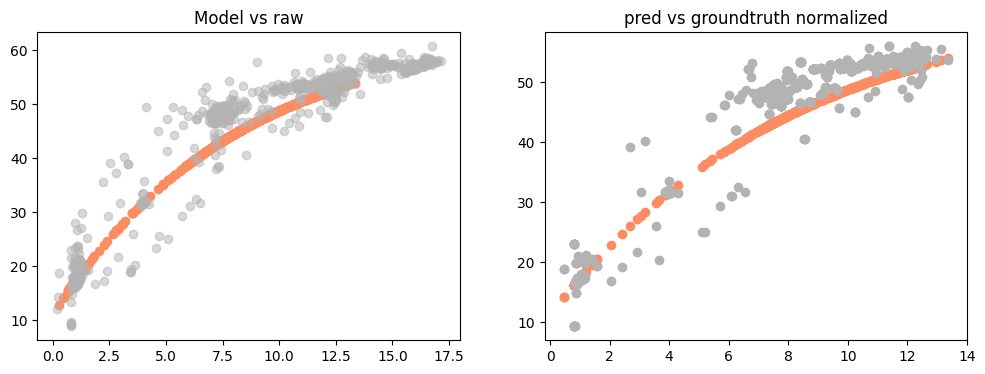

In [4]:
core_host_ref = {'nova':32, 'grappe': 80, 'servan':96, 'chuc':64, 'chirop':128, 'grue':64}
core_host = core_host_ref['nova']
vm_size=4
exclude_beyond = (vm_size * 100) / core_host * 3
model_dict = compute_models(training_dict=training_dict, exclude_beyond=exclude_beyond, verbose=False, display=False)

# Groundtruth
groundtruth = dataset_gt.dropna()
groundtruth = groundtruth.assign(host_percent_vm = groundtruth.vm / core_host)

# Prediction on cloud-like dataset
cloudlike = dataset_cl.dropna()
cloudlike = cloudlike.assign(host_percent_vm = cloudlike.vm / core_host)
cloudlike['prediction'] = cloudlike.apply(lambda row : estimate(model_dict, row, core_host), axis=1)

colors = sns.color_palette("Set2", 8)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 4))
ax1.scatter(cloudlike['host_percent_vm'], cloudlike['prediction'], color=colors[1], label='prediction')
ax1.scatter(groundtruth['host_percent_vm'], groundtruth['package-global-watt'], color=colors[-1], label='groundtruth', alpha=0.5)
ax1.title.set_text('Model vs raw')

# Evaluation

evaluation_df = cloudlike
evaluation_df.assign(host_percent_vm = evaluation_df.vm / core_host)
evaluation_df['groundtruth'] = evaluation_df.apply(lambda row : get_closest_val(groundtruth, 'host_percent_vm', row, 'package-global-watt'), axis=1)
evaluation_df['prediction'] = evaluation_df.apply(lambda row : estimate(model_dict, row, core_host), axis=1)
evaluation_df.dropna(inplace=True)
y = evaluation_df['groundtruth']
y_predict = evaluation_df['prediction']

print('formula', formula_as_str(*model_dict['50']))
print('r2_score /1', r2_score(y,y_predict))
print('root mean squared error', root_mean_squared_error(y,y_predict))
print('mean absolut error', mean_absolute_error(y, y_predict))

ax2.scatter(evaluation_df['host_percent_vm'], evaluation_df['prediction'], color=colors[1])
ax2.scatter(evaluation_df['host_percent_vm'], evaluation_df['groundtruth'], color=colors[-1])
ax2.title.set_text('pred vs groundtruth normalized')


# Evaluation - multiple hosts

In [5]:
folder_source = {}

path_root = '/home/pierre/src/cinergy-models/'
folder_source['nova']   = path_root + 'data/241029-nova/nova-12.lyon.grid5000.fr-XXX.csv' # Xeon 2016 (16/32, dual)
folder_source['grappe'] = path_root + 'data/241030-grappe/grappe-11.nancy.grid5000.fr-XXX.csv' # Xeon 2020 (40/80, dual)
folder_source['chirop'] = path_root + 'data/241031-chirop/chirop-4.lille.grid5000.fr-XXX.csv' # Xeon 2021 (64/128, dual)

folder_source['grue']   = path_root + 'data/241031-grue/grue-2.nancy.grid5000.fr-XXX.csv' # Zen 1 (32/64, dual)
folder_source['servan'] = path_root + 'data/241030-servan/servan-2.grenoble.grid5000.fr-XXX.csv' # Zen 2 (48/96, dual)
folder_source['chuc']   = path_root + 'data/241030-chuc/chuc-6.lille.grid5000.fr-XXX.csv' # Zen 3 (32/64, single)

data_source = {}
for name, folder in folder_source.items():
    training_dict = {}
    training_dict['25'] = format_csv(folder.replace('XXX', 'training-25'))
    training_dict['50'] = format_csv(folder.replace('XXX', 'training-50'))
    training_dict['100'] = format_csv(folder.replace('XXX', 'training-100'))
    dataset_gt = format_csv(folder.replace('XXX', 'groundtruth') )
    dataset_cl = format_csv(folder.replace('XXX', 'cloudlike'))
    data_source[name] = (training_dict, dataset_gt, dataset_cl)
    print(name, 'loaded')

nova loaded
grappe loaded
chirop loaded
grue loaded
servan loaded
chuc loaded


In [6]:
# Model to apply
def estimate(model_dict : dict, value, core_host : int = None, keys : list = ['CPU0', 'CPU1', 'CPU2', 'CPU3']):
    if core_host is not None:
        return estimate_from_model(model_dict['50'], value['vm']/core_host, include_static=True)
    return estimate_from_model(model_dict['50'], value, include_static=True)

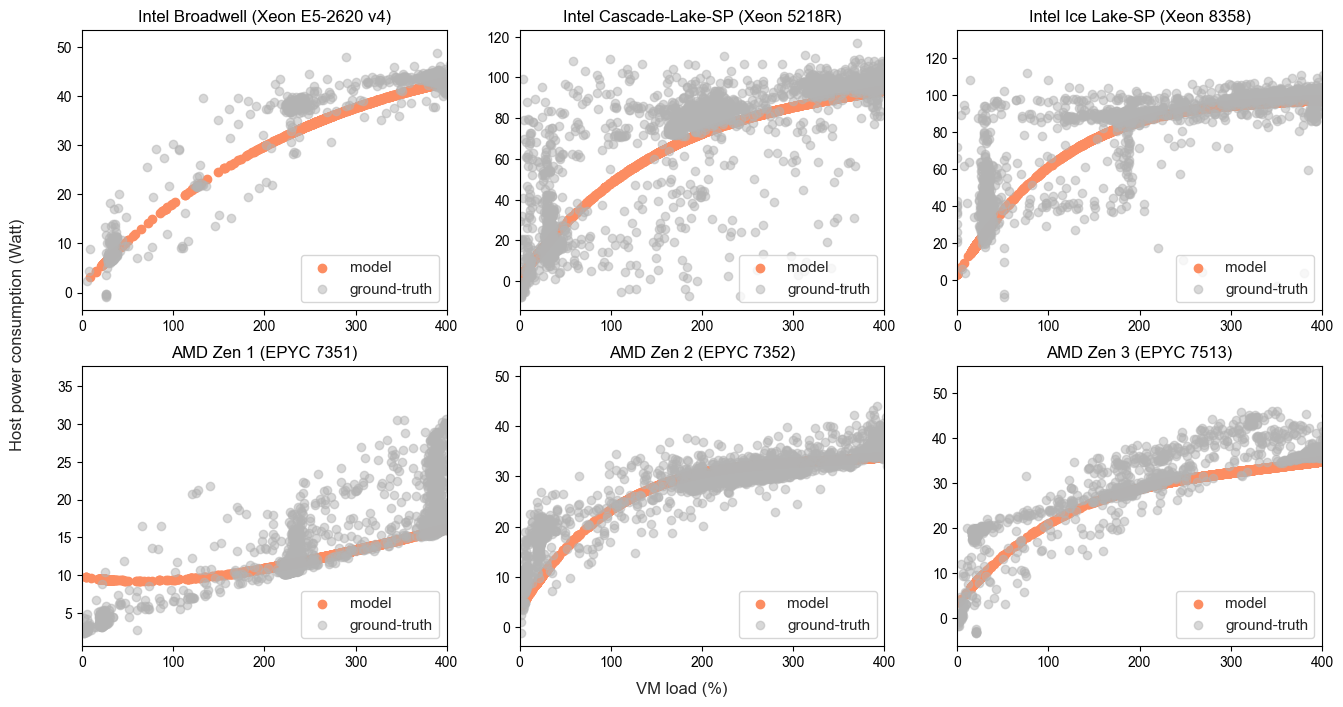

In [7]:
fig, axes = plt.subplots(2,int(len(data_source)/2), figsize=(16, 8))
index = 0

core_host_ref = {'nova':32, 'grappe': 80, 'servan':96, 'chuc':64, 'chirop':128, 'grue':64}
labels_figure = {'nova':'Intel Broadwell (Xeon E5-2620 v4)', 'grappe': 'Intel Cascade-Lake-SP (Xeon 5218R)', 'chirop': 'Intel Ice Lake-SP (Xeon 8358)', 
                 'grue':'AMD Zen 1 (EPYC 7351)', 'servan':'AMD Zen 2 (EPYC 7352)', 'chuc':'AMD Zen 3 (EPYC 7513)'}
sns.set_theme(style="whitegrid", palette="husl")
for name, data in data_source.items():
    (training_dict, dataset_gt, dataset_cl) = data
    vm_size = 4
    core_host = core_host_ref[name]
    exclude_beyond = (vm_size * 100) / core_host * 3
    model_dict = compute_models(training_dict=training_dict, exclude_beyond=exclude_beyond, verbose=False, display=False)

    # Groundtruth
    remove_static = estimate(model_dict, 0) * (1 - (vm_size/core_host))
    core_host = core_host_ref[name]
    groundtruth = dataset_gt.dropna()
    groundtruth = groundtruth.assign(host_percent_vm = groundtruth.vm / core_host)
    groundtruth['package-global-watt-norm'] = groundtruth['package-global-watt'] - remove_static
    
    # Prediction on cloudlike dataset
    cloudlike = dataset_cl.dropna()
    cloudlike = cloudlike.assign(host_percent_vm = cloudlike.vm / core_host)
    cloudlike['prediction'] = cloudlike.apply(lambda row : estimate(model_dict, row, core_host), axis=1)
    cloudlike['prediction-norm'] = cloudlike['prediction'] - remove_static

    colors = sns.color_palette("Set2", 8)
    axes.flat[index].scatter(cloudlike['vm'], cloudlike['prediction-norm'], color=colors[1], label='model')
    axes.flat[index].scatter(groundtruth['vm'], groundtruth['package-global-watt-norm'], color=colors[-1], label='ground-truth', alpha=0.5)
    axes.flat[index].set_xlim(0,400)
    axes.flat[index].title.set_text(labels_figure[name])
    axes.flat[index].legend(loc="lower right")
    index+=1

fig.text(0.08, 0.5, 'Host power consumption (Watt)', va='center', rotation='vertical')
fig.text(0.5, 0.05, 'VM load (%)', ha='center')
plt.gcf().savefig('figures/power-model-vm.pdf', bbox_inches='tight')
plt.show()

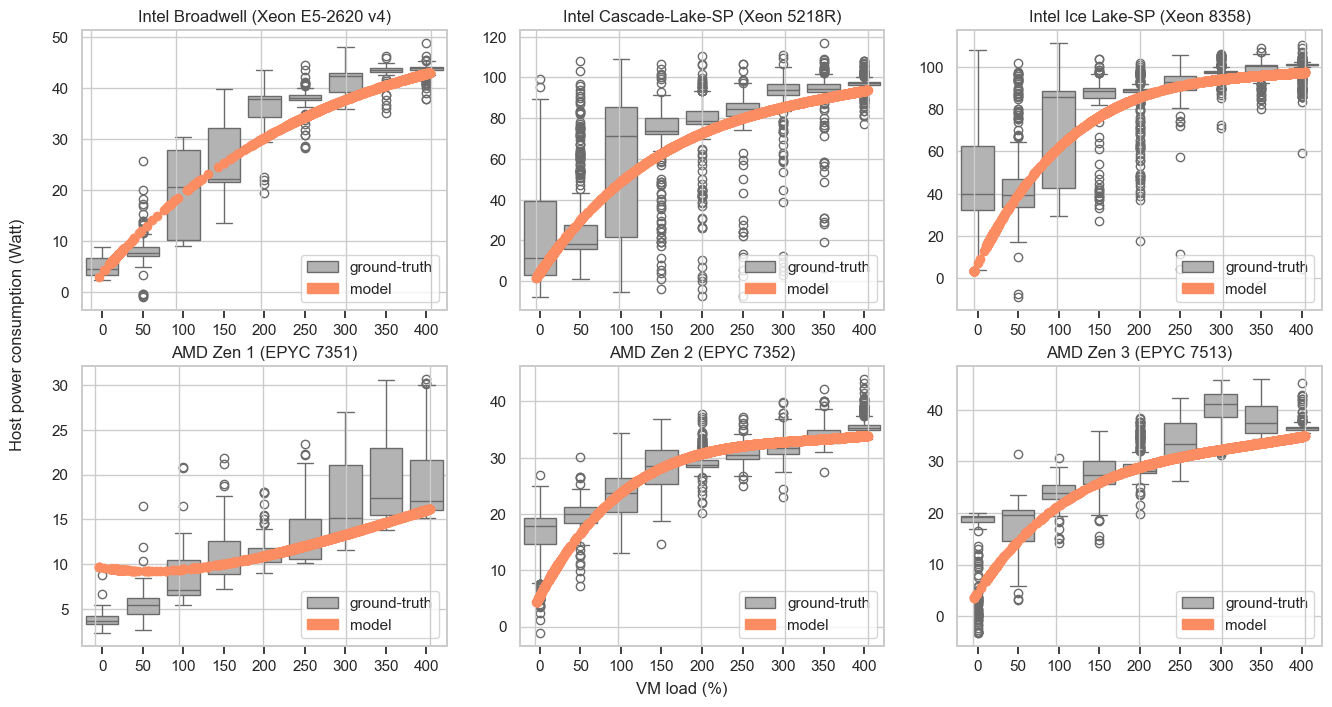

In [8]:
fig, axes = plt.subplots(2,int(len(data_source)/2), figsize=(16, 8))
index = 0

core_host_ref = {'nova':32, 'grappe': 80, 'servan':96, 'chuc':64, 'chirop':128, 'grue':64}
labels_figure = {'nova':'Intel Broadwell (Xeon E5-2620 v4)', 'grappe': 'Intel Cascade-Lake-SP (Xeon 5218R)', 'chirop': 'Intel Ice Lake-SP (Xeon 8358)', 
                 'grue':'AMD Zen 1 (EPYC 7351)', 'servan':'AMD Zen 2 (EPYC 7352)', 'chuc':'AMD Zen 3 (EPYC 7513)'}
sns.set_theme(style="whitegrid", palette="husl")
for name, data in data_source.items():
    (training_dict, dataset_gt, dataset_cl) = data
    vm_size = 4
    core_host = core_host_ref[name]
    exclude_beyond = (vm_size * 100) / core_host * 3
    model_dict = compute_models(training_dict=training_dict, exclude_beyond=exclude_beyond, verbose=False, display=False)

    # Groundtruth
    remove_static = estimate(model_dict, 0) * (1 - (vm_size/core_host))
    core_host = core_host_ref[name]
    groundtruth = dataset_gt.dropna()
    groundtruth = groundtruth.assign(host_percent_vm = groundtruth.vm / core_host)
    groundtruth = groundtruth.loc[groundtruth['vm'] <= 400]
    groundtruth['package-global-watt-norm'] = groundtruth['package-global-watt'] - remove_static
    groundtruth['vm-norm'] = groundtruth['vm'].apply(lambda x : (50*round(x/50)) )

    # Prediction on cloudlike dataset
    cloudlike = dataset_cl.dropna()
    cloudlike = cloudlike.assign(host_percent_vm = cloudlike.vm / core_host)
    cloudlike = cloudlike.loc[cloudlike['vm'] <= 400]
    cloudlike['prediction'] = cloudlike.apply(lambda row : estimate(model_dict, row, core_host), axis=1)
    cloudlike['prediction-norm'] = cloudlike['prediction'] - remove_static
    cloudlike['vm-norm'] = cloudlike['vm'].apply(lambda x : (50*round(x/50)) )

    colors = sns.color_palette("Set2", 8)
    sns.boxplot(data=groundtruth, x="vm-norm", y="package-global-watt-norm", ax=axes.flat[index], color=colors[-1], label='ground-truth')
    axes.flat[index].set(ylabel="", xlabel="")
    axes.flat[index].title.set_text(labels_figure[name])
    
    twin = axes.flat[index].twiny()
    twin.tick_params(top=False, labeltop=False, left=False, labelleft=False, right=False, labelright=False, bottom=False, labelbottom=False)
    twin.scatter(cloudlike['vm'], cloudlike['prediction-norm'], color=colors[1], label='model')
    
    import matplotlib
    #labels = [l.get_label() for l in lns]
    lines, labels   = axes.flat[index].get_legend_handles_labels()
    lines2, labels2 = twin.get_legend_handles_labels()
    custom_form = matplotlib.patches.PathPatch(lines[0])
    custom_form.set_edgecolor(lines2[0].get_edgecolor())
    custom_form.set_facecolor(lines2[0].get_facecolor())
    axes.flat[index].legend(lines + [custom_form], labels + labels2, loc="lower right")

    index+=1

fig.text(0.08, 0.5, 'Host power consumption (Watt)', va='center', rotation='vertical')
fig.text(0.5, 0.05, 'VM load (%)', ha='center')
plt.gcf().savefig('figures/power-model-vm.pdf', bbox_inches='tight')
plt.show()


formula f(x) = 11.235481 + 0.0*(x**0) + 6.3795543*(x**1) + -0.34779748*(x**2) + 0.009526834*(x**3) + -9.8228455e-05*(x**4)
nova r2_score /1 0.852739476098813
nova root mean squared error 3.769155386083325
nova mape (%) 0.07178385537443863

formula f(x) = 34.95479 + 0.0*(x**0) + 49.510826*(x**1) + -11.559776*(x**2) + 1.445102*(x**3) + -0.08487272*(x**4) + 0.0018844604*(x**5)
grappe r2_score /1 0.5300507549163275
grappe root mean squared error 20.21482889324463
grappe mape (%) 0.1510729127335493

formula f(x) = 107.39987 + 0.0*(x**0) + 104.895195*(x**1) + -46.960217*(x**2) + 10.195637*(x**3) + -1.0253248*(x**4) + 0.03870392*(x**5)
chirop r2_score /1 0.6043493298874052
chirop root mean squared error 14.930682475911963
chirop mape (%) 0.055072953837879655

formula f(x) = 156.33894 + 0.0*(x**0) + -1.1065882*(x**1) + 0.65153205*(x**2) + -0.06831849*(x**3) + 0.003387995*(x**4) + -6.341934e-05*(x**5)
grue r2_score /1 0.28486852791659867
grue root mean squared error 6.75949864308693
grue mape (

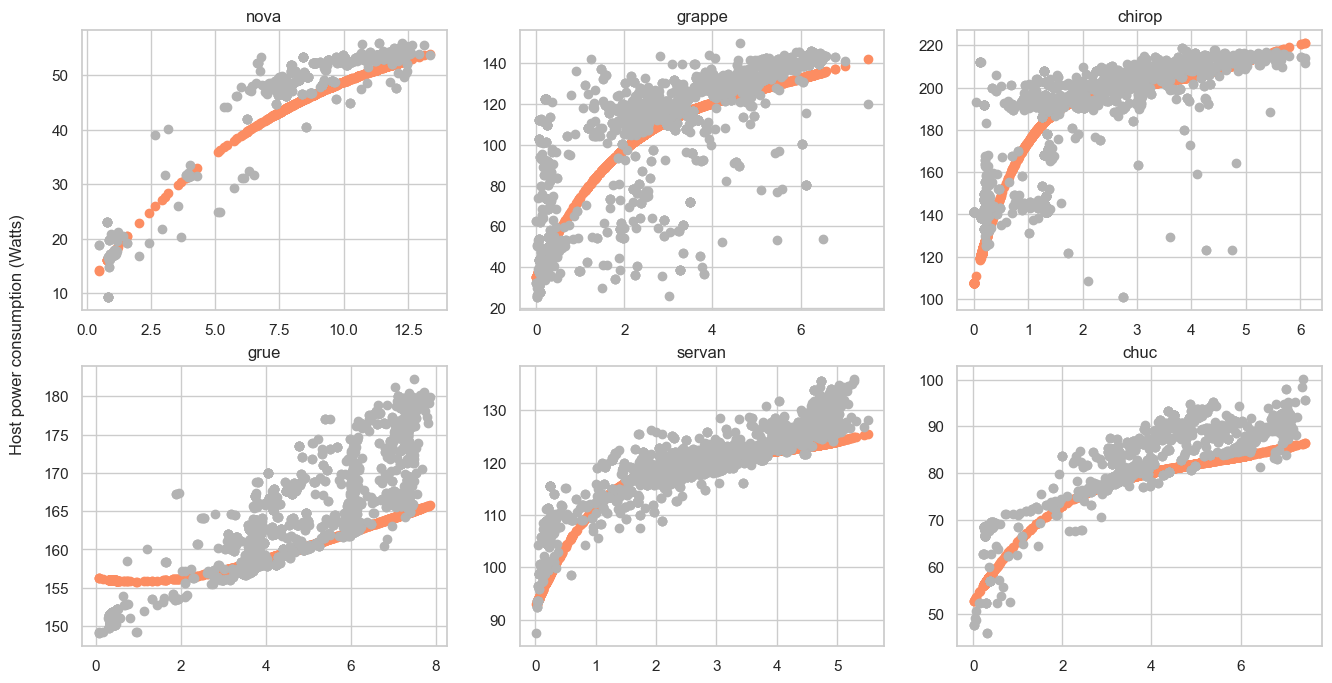

In [9]:
core_host_ref = {'nova':32, 'grappe': 80, 'servan':96, 'chuc':64, 'chirop':128, 'grue':64}
fig, axes = plt.subplots(2,int(len(data_source)/2), figsize=(16, 8))
index = 0

sns.set_theme(style="whitegrid", palette="husl")
for name, data in data_source.items():
    (training_dict, dataset_gt, dataset_cl) = data
    core_host = core_host_ref[name]

    vm_size = 4
    exclude_beyond = (vm_size * 100) / core_host * 3
    model_dict = compute_models(training_dict=training_dict, exclude_beyond=exclude_beyond, verbose=False, display=False)

    # Groundtruth
    groundtruth = dataset_gt.dropna()
    groundtruth = groundtruth.assign(host_percent_vm = groundtruth.vm / core_host)
    
    # Prediction on cloudlike dataset
    cloudlike = dataset_cl.dropna()
    cloudlike = cloudlike.assign(host_percent_vm = cloudlike.vm / core_host)

    evaluation_df = cloudlike
    evaluation_df.assign(host_percent_vm = evaluation_df.vm / core_host)
    evaluation_df['groundtruth'] = evaluation_df.apply(lambda row : get_closest_val(groundtruth, 'host_percent_vm', row, 'package-global-watt'), axis=1)
    evaluation_df['prediction'] = evaluation_df.apply(lambda row : estimate(model_dict, row, core_host), axis=1)
    evaluation_df.dropna(inplace=True)
    y = evaluation_df['groundtruth']
    y_predict = evaluation_df['prediction']

    print('formula', formula_as_str(*model_dict['50']))
    print(name, 'r2_score /1', r2_score(y,y_predict))
    print(name, 'root mean squared error', root_mean_squared_error(y,y_predict))
    #print(name, 'mean absolut error', mean_absolute_error(y, y_predict))
    print(name, 'mape (%)', mean_absolute_percentage_error(y, y_predict))
    print('')

    colors = sns.color_palette("Set2", 8)
    axes.flat[index].scatter(evaluation_df['host_percent_vm'], evaluation_df['prediction'], color=colors[1])
    axes.flat[index].scatter(evaluation_df['host_percent_vm'], evaluation_df['groundtruth'], color=colors[-1])
    axes.flat[index].title.set_text(name)
    index+=1

fig.text(0.08, 0.5, 'Host power consumption (Watts)', va='center', rotation='vertical')
plt.show()

# Motivation design

50 - best degree 3 formula: f(x) = 22.641785 + 0.0*(x**0) + 2.502298*(x**1) + -0.038995862*(x**2) + 0.00021338463*(x**3)
50 - r2_score /1 0.9762140512466431
50 - RMSE 2.5195222
50 - mean absolute error 1.7276602
50 - best degree 5 formula: f(x) = 11.384085 + 0.0*(x**0) + 5.4465337*(x**1) + 0.041912097*(x**2) + -0.04320895*(x**3) + 0.00273934*(x**4) + -5.2928925e-05*(x**5)
50 - r2_score /1 0.9857684373855591
50 - RMSE 1.7163539
50 - mean absolute error 1.2086504

r2_score /1 0.9762140512466431
root mean squared error 2.5195222
mean absolut error 1.7276602

r2_score /1 0.8384531140327454
root mean squared error 5.46296
mean absolut error 4.6189394


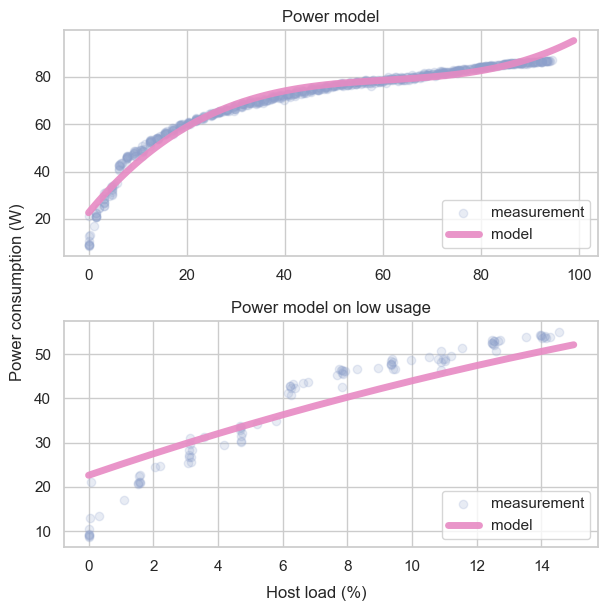

In [10]:
path_root = '/home/pierre/src/cinergy-models/'

folder_target = path_root + 'data/241029-nova/nova-12.lyon.grid5000.fr-XXX.csv' # Xeon 2016 (16/32, dual)
# folder_target = path_root + 'data/241030-grappe/grappe-11.nancy.grid5000.fr-XXX.csv' # Xeon 2020 (40/80, dual)
# folder_target = path_root + 'data/241031-chirop/chirop-4.lille.grid5000.fr-XXX.csv' # Xeon 2021 (64/128, dual)
# folder_target = path_root + 'data/241031-grue/grue-2.nancy.grid5000.fr-XXX.csv' # Zen 1 (32/64, dual)
# folder_target = path_root + 'data/241030-servan/servan-2.grenoble.grid5000.fr-XXX.csv' # Zen 2 (48/96, dual)
# folder_target = path_root + 'data/241030-chuc/chuc-6.lille.grid5000.fr-XXX.csv' # Zen 3 (32/64, single)

training_dict =  {}
training_dict['50'] = format_csv(folder_target.replace('XXX', 'training-50'))

model_without = compute_models(training_dict=training_dict, exclude_beyond=None, verbose=True, display=False)
model_with = compute_models(training_dict=training_dict, exclude_beyond=20, verbose=True, display=False)

colors = sns.color_palette("Set2", 8)
fig, (ax1, ax2) = plt.subplots(2,1,  figsize=(6, 6))

ax1.scatter(training_dict['50']['cpu%_package-global'], training_dict['50']['package-global-watt'], color=colors[2], label='measurement', alpha=0.2)
ax1.plot(range(100), [estimate_from_model(model_without['50'], x, include_static=True) for x in range(100)], color=colors[3], label='model', alpha=0.9, linewidth=5.0)
ax1.title.set_text('Power model')
ax1.legend(loc="lower right")

indicator = training_dict['50'].dropna()
print('')
print('r2_score /1', r2_score(indicator['package-global-watt'], [estimate_from_model(model_without['50'], x, include_static=True) for x in indicator['cpu%_package-global']]))
print('root mean squared error', root_mean_squared_error(indicator['package-global-watt'], [estimate_from_model(model_without['50'], x, include_static=True) for x in indicator['cpu%_package-global']]))
print('mean absolut error', mean_absolute_error(indicator['package-global-watt'], [estimate_from_model(model_without['50'], x, include_static=True) for x in indicator['cpu%_package-global']]))

zoom = training_dict['50'].loc[training_dict['50']['cpu%_package-global'] <= 15 ]
ax2.scatter(zoom['cpu%_package-global'], zoom['package-global-watt'], color=colors[2], label='measurement', alpha=0.2)
ax2.plot(range(15+1), [estimate_from_model(model_without['50'], x, include_static=True) for x in range(15+1)], color=colors[3], label='model', alpha=0.9, linewidth=5.0)

indicator = zoom.dropna()
print('')
print('r2_score /1', r2_score(indicator['package-global-watt'], [estimate_from_model(model_without['50'], x, include_static=True) for x in indicator['cpu%_package-global']]))
print('root mean squared error', root_mean_squared_error(indicator['package-global-watt'], [estimate_from_model(model_without['50'], x, include_static=True) for x in indicator['cpu%_package-global']]))
print('mean absolut error', mean_absolute_error(indicator['package-global-watt'], [estimate_from_model(model_without['50'], x, include_static=True) for x in indicator['cpu%_package-global']]))

ax2.title.set_text('Power model on low usage')
ax2.legend(loc="lower right")

#fig.text(0.45,-0.04, 'Host load (%)', ha='center')
fig.tight_layout()

fig.text(0.5, -0.01, 'Host load (%)', ha='center')
fig.text(-0.01, 0.5, 'Power consumption (W)', va='center', rotation='vertical')

plt.gcf().savefig('figures/design.pdf', bbox_inches='tight')
plt.show()

## Cinergy ratio

In [ ]:
core_host_ref = {'nova':32, 'grappe': 80, 'servan':96, 'chuc':64, 'chirop':128, 'grue':64}
core_host = core_host_ref['nova']

path_root = '/home/pierre/src/cinergy-models/'
folder_target = path_root + 'data/241129-nova/nova-9.lyon.grid5000.fr-cloudlike.csv' # Xeon 2016 (16/32, dual)
dataset_cl = format_csv(folder_target.replace('XXX', 'cloudlike'))
cloudlike = dataset_cl.dropna()
cloudlike = cloudlike.assign(host_percent_vm = cloudlike.vm / core_host)
cloudlike['prediction'] = cloudlike.apply(lambda row : estimate(model_dict, row, core_host), axis=1)

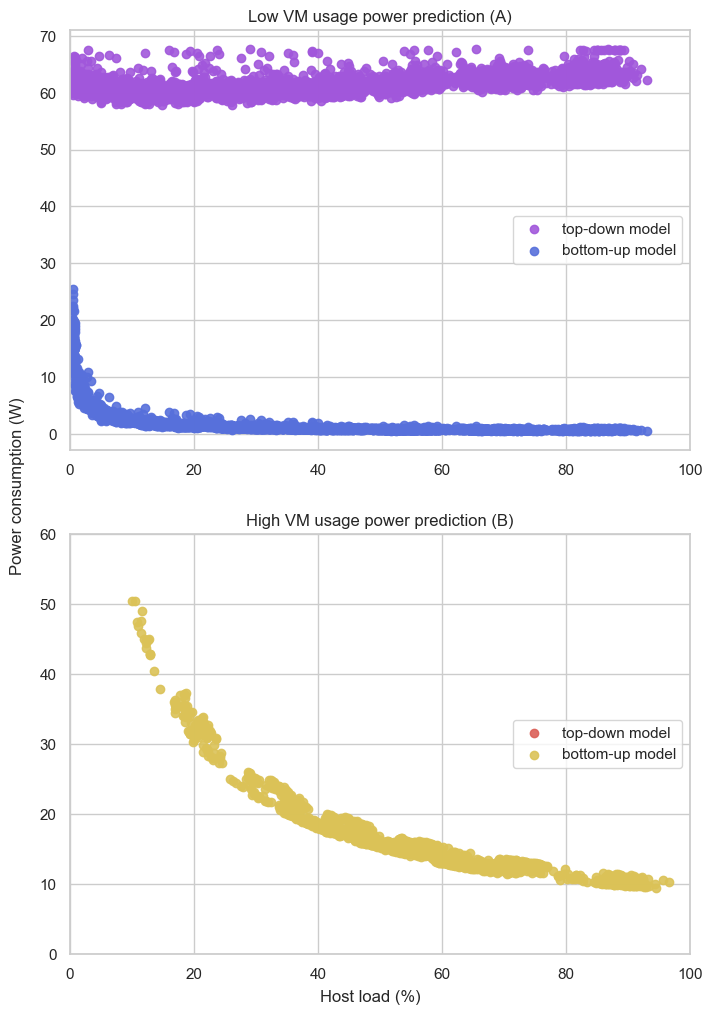

In [18]:
core_host = core_host_ref['nova']
remove_static = estimate(model_dict, 0) * (1 - (vm_size/core_host))

cloudlike['top-down']  = cloudlike['prediction']
cloudlike['bottom-up'] = cloudlike.apply(lambda row : (row['host_percent_vm']/(row['host_percent_vm']+row['target']))*row['package-global-watt'], axis=1)
cloudlike['bottom-up'] = cloudlike.apply(lambda row : (row['host_percent_vm']/row['cpu%_package-global'])*row['package-global-watt'], axis=1)
cloudlike['model-ratio'] = cloudlike['bottom-up']/cloudlike['top-down']

low_phase = cloudlike.loc[cloudlike['vm'].between((400)*0.01,(400)*0.10,inclusive='both')]
high_phase = cloudlike.loc[cloudlike['vm'].between((400)*0.85,(400),inclusive='both')]

sns.set_theme(style="whitegrid", palette="husl")
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8, 12))

colors = sns.color_palette("hls", 8)
ax1.scatter(low_phase['cpu%_package-global'], low_phase['top-down'], color=colors[6],   label='top-down model', alpha=0.9)
ax1.scatter(low_phase['cpu%_package-global'], low_phase['bottom-up'], color=colors[5],   label='bottom-up model', alpha=0.9)
ax1.title.set_text('Low VM usage power prediction (A)')
ax1.set_ylabel('')
ax1.set_xlim(0,100)
ax1.legend(loc="center right")

ax2.scatter(high_phase['cpu%_package-global'], high_phase['top-down'], color=colors[0],   label='top-down model', alpha=0.9)
ax2.scatter(high_phase['cpu%_package-global'], high_phase['bottom-up'], color=colors[1],   label='bottom-up model', alpha=0.9)
ax2.title.set_text('High VM usage power prediction (B)')
ax2.set_ylabel('')
ax2.legend(loc="center right")
ax2.set_xlim(0,100)
ax2.set_ylim(0,60)

fig.text(0.05, 0.5, 'Power consumption (W)', va='center', rotation='vertical')
fig.text(0.5, 0.07, 'Host load (%)', ha='center')

plt.gcf().savefig('figures/top-and-bottom.pdf', bbox_inches='tight')

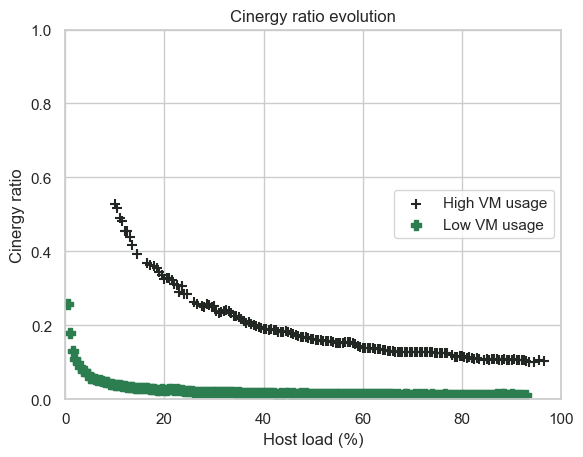

In [16]:
greencolors = sns.dark_palette("seagreen", 8)
ax = sns.regplot(high_phase, x_bins=np.arange(0, 100, 0.5), marker='+', line_kws=dict(alpha=0), ci=None, x='cpu%_package-global', y='model-ratio', color=greencolors[0], label='High VM usage')
sns.regplot(low_phase, x_bins=np.arange(0, 100, 0.5), marker='P', line_kws=dict(alpha=0), ci=None, x='cpu%_package-global', y='model-ratio', color=greencolors[6], label='Low VM usage', ax=ax)
ax.title.set_text('Cinergy ratio evolution')
ax.set_ylabel('Cinergy ratio')
ax.set_xlabel('Host load (%)')
ax.legend(loc="center right")
ax.set_xlim(0,100)
ax.set_ylim(0,1)

plt.gcf().savefig('figures/cinergy-ratio.pdf', bbox_inches='tight')

best degree 3 formula: f(x) = 0.63130856 + 0.0*(x**0) + -0.019227123*(x**1) + 0.00025577113*(x**2) + -1.1902303e-06*(x**3)


<Axes: >

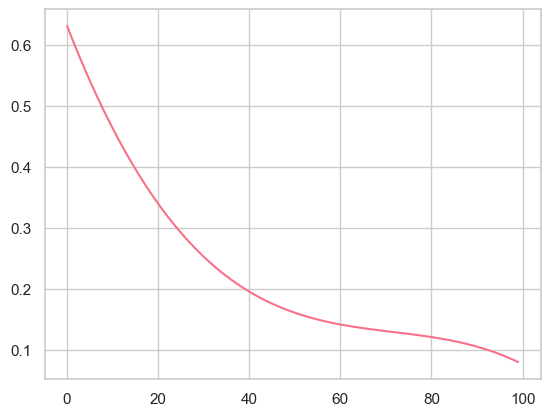

In [15]:
x = high_phase['cpu%_package-global'] 
y = high_phase['model-ratio'] 
degree = best_degree(x,y)
polynomial_features= PolynomialFeatures(degree=degree)
x_poly = polynomial_features.fit_transform(pd.DataFrame(x))

model = LinearRegression()
reg = model.fit(x_poly, y)
y_predict = model.predict(x_poly)

print('best degree', degree, 'formula:', formula_as_str(reg.intercept_, reg.coef_))

sns.lineplot(x=range(100), y=[estimate_from_model((reg.intercept_, reg.coef_), x) for x in range(100)])